In [ ]:
! pip install numpyro corner healpy einops reproject

In [ ]:
# run only if LaTeX is needed
! sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

In [3]:
import sys
from google.colab import drive
drive.mount('/content/drive')
sys.path.append(r'/content/drive/Othercomputers/My MacBook Pro/gce-prob-prog/')
%cd /content/drive/Othercomputers/My MacBook Pro/gce-prob-prog/notebooks

Mounted at /content/drive
/content/drive/Othercomputers/My MacBook Pro/gce-prob-prog/notebooks


In [4]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import numpy as np
import healpy as hp
from astropy.io import fits
from pprint import pprint
from tqdm import tqdm
import pickle
import corner
import os

from scipy import optimize
from scipy.stats import poisson

import jax

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('matplotlibrc')

## 0. Load model

In [5]:
from models.poissonian import EbinPoissonModel

In [6]:
ebinmodel = EbinPoissonModel(nside=128)

In [7]:
output_dir = '../output/posteriors'

## 1. Compare different fitting methods

### 1.1 Stochastic Variational Inference (SVI)
Takes $\sim$2 minutes to run on a V100.

In [ ]:
ebinmodel.config_model(ebin=10)
svi_results = ebinmodel.fit_SVI(
    rng_key=jax.random.PRNGKey(4242),
    guide="iaf", num_flows=5, hidden_dims=[128, 128],
    n_steps=10000, lr=5e-5, num_particles=8,
    ebin=10,
)

100%|██████████| 10000/10000 [00:38<00:00, 259.17it/s, init loss: 83348.7031, avg. loss [9501-10000]: 13348.7559]


In [ ]:
samples = ebinmodel.get_svi_samples(num_samples=50000)
pickle.dump((samples, svi_results), open(f'{output_dir}/check_SVI/ebin10_smp_svi.p', 'wb'))

### 1.2 Parallel Tempering Hamiltonian Monte Carlo (PTHMC)
With or without neutral transport (neutra). $\sim$20 minutes to run on a V100. \
To use neutra, must run SVI first.

In [ ]:
from jax.config import config
config.update("jax_enable_x64", True)

In [ ]:
ebinmodel.run_parallel_tempering_hmc(num_samples=50000, use_neutra=False)

In [ ]:
samples = ebinmodel.expand_samples(ebinmodel.pt_mcmc.get_samples())
pickle.dump(samples, open(f'{output_dir}/check_SVI/ebin10_pthmc.p', 'wb'))

### 1.3 Maximum a Posteriori (MAP)
Point estimate with prior folded in. $\sim$ 1 minute to run. Uses SVI with a delta function $\delta^n(\theta-\theta_0)$ guide, where $n$ is the number of dimensions of the fit.

In [ ]:
svi_results = ebinmodel.fit_MAP(n_steps=30000, ebin=10)

100%|██████████| 30000/30000 [01:07<00:00, 441.51it/s, init loss: 374037.0625, avg. loss [28501-30000]: 31911.5488]


In [ ]:
ebinmodel.MAP_estimates['f_blg'] = ebinmodel.MAP_estimates['S_blg'] / (ebinmodel.MAP_estimates['S_blg'] + ebinmodel.MAP_estimates['S_nfw'])
pickle.dump(
    (ebinmodel.expand_samples(ebinmodel.MAP_estimates), svi_results),
    open(f'{output_dir}/check_SVI/ebin10_MAP.p', 'wb'),
)

### 1.4 compare

In [ ]:
samples_dict = {
    'SVI 1' : pickle.load(open(f'{output_dir}/check_SVI/ebin10_smp_svi.p', 'rb'))[0],
    'SVI 2' : pickle.load(open(f'{output_dir}/check_SVI/ebin10_smp_svi_2.p', 'rb'))[0],
    'SVI 3' : pickle.load(open(f'{output_dir}/check_SVI/ebin10_smp_svi_3.p', 'rb'))[0],
    'PTHMC NT' : pickle.load(open(f'{output_dir}/check_SVI/ebin10_pthmc_nt.p', 'rb')),
    'PTHMC' : pickle.load(open(f'{output_dir}/check_SVI/ebin10_pthmc.p', 'rb')),
}
colors_dict = {
    'SVI 1' : mpl.colormaps['viridis'](0.6),
    'SVI 2' : mpl.colormaps['viridis'](0.7),
    'SVI 3' : mpl.colormaps['viridis'](0.8),
    'PTHMC NT' : mpl.colormaps['binary'](0.9),
    'PTHMC' : mpl.colormaps['binary'](0.5),
}
names_dict = {
    'SVI 1' : 'SVI run 1',
    'SVI 2' : 'SVI run 2',
    'SVI 3' : 'SVI run 3',
    'PTHMC NT' : 'PTHMC with NeuTra',
    'PTHMC' : 'PTHMC',
}

plot_var_names = [
    'S_iso', 'S_nfw', 'S_blg', 'f_blg', 'gamma', 'S_pib', 'S_ics',
    'theta_pib_modelo', 'theta_blg_coleman2019',
]

n_bins_1d = 30
bins_1d_arr = [] # for a custom corner.py that makes the binning match
range_arr = []
for vn in plot_var_names:
    vmin = np.min([np.min(s[vn]) for _, s in samples_dict.items()])
    vmax = np.max([np.max(s[vn]) for _, s in samples_dict.items()])
    bins_1d_arr.append(np.linspace(vmin, vmax, n_bins_1d + 1))
    range_arr.append([vmin, vmax])

figure = None
for i, (samples_name, samples) in enumerate(samples_dict.items()):
    color = mpl.colors.to_hex(colors_dict[samples_name])
    figure = corner.corner(
        samples,
        bins_1d_arr=bins_1d_arr, # for a custom corner.py that makes the binning match
        range=range_arr,
        var_names=plot_var_names,
        show_titles=True,
        title_kwargs={"fontsize": 12},
        levels=[0.68, 0.95],
        color=color,
        plot_contours=True,
        fill_contours=False,
        plot_density=False,
        plot_datapoints=False,
        fig=figure,
    )
    #figure.text(0.5, 0.6+0.012*i, samples_name, fontsize=16, color=color)

ndim = len(plot_var_names)
axs = np.array(figure.axes).reshape((ndim, ndim))
MAP_estimates, _ = pickle.load(open(f'{output_dir}/check_SVI/ebin10_MAP.p', 'rb'))
for i, v in enumerate(plot_var_names):
    axs[i,i].axvline(MAP_estimates[v], color='k')
for ri in range(ndim):
    for ci in range(ri):
        axs[ri,ci].plot(MAP_estimates[plot_var_names[ci]], MAP_estimates[plot_var_names[ri]], '*', color='k', ms=10)

figure.legend(
    [mpl.lines.Line2D([0], [0], color=c) for k, c in colors_dict.items()],
    [names_dict[k] for k, c in colors_dict.items()],
    loc=(0.3, 0.9)
)
plt.savefig(f'{output_dir}/plots/compare_SVI.pdf')

## 2. SVI for all energy bins

In [14]:
for ie in range(10, 20):
    print('ebin: ', ie)
    ebinmodel.config_model(ebin=ie)
    svi_results = ebinmodel.fit_SVI(
        rng_key=jax.random.PRNGKey(42),
        guide="iaf", num_flows=5, hidden_dims=[128, 128],
        n_steps=10000, lr=5e-5, num_particles=8,
        ebin=ie,
    )
    samples = ebinmodel.get_svi_samples(num_samples=50000)
    pickle.dump((samples, svi_results), open(f'{output_dir}/test_bin{ie}.p', 'wb'))

ebin:  10


100%|██████████| 10000/10000 [00:37<00:00, 263.35it/s, init loss: 85170.0156, avg. loss [9501-10000]: 13348.3545]


ebin:  11


100%|██████████| 10000/10000 [00:39<00:00, 255.62it/s, init loss: 99953.2812, avg. loss [9501-10000]: 12166.0029]


ebin:  12


100%|██████████| 10000/10000 [00:37<00:00, 264.92it/s, init loss: 114605.0156, avg. loss [9501-10000]: 10979.1748]


ebin:  13


100%|██████████| 10000/10000 [00:39<00:00, 255.69it/s, init loss: 127249.4219, avg. loss [9501-10000]: 9695.1982]


ebin:  14


100%|██████████| 10000/10000 [00:38<00:00, 256.95it/s, init loss: 137967.5938, avg. loss [9501-10000]: 9618.9375]


ebin:  15


100%|██████████| 10000/10000 [00:38<00:00, 259.20it/s, init loss: 146023.8438, avg. loss [9501-10000]: 8103.9863]


ebin:  16


100%|██████████| 10000/10000 [00:38<00:00, 261.03it/s, init loss: 151660.7188, avg. loss [9501-10000]: 6689.9507]


ebin:  17


100%|██████████| 10000/10000 [00:38<00:00, 261.31it/s, init loss: 156267.6094, avg. loss [9501-10000]: 5396.3813]


ebin:  18


100%|██████████| 10000/10000 [00:38<00:00, 260.45it/s, init loss: 159789.6562, avg. loss [9501-10000]: 4414.5430]


ebin:  19


100%|██████████| 10000/10000 [00:39<00:00, 256.12it/s, init loss: 161710.9219, avg. loss [9501-10000]: 3582.0852]


## 3. View

In [19]:
samples_arr = []
for ie in range(10, 20):
    samples_arr.append(pickle.load(open(f'{output_dir}/test_bin{ie}.p', 'rb'))[0])
    if 'auto_shared_latent' in samples_arr[-1]:
        samples_arr[-1].pop('auto_shared_latent')
        print(f'{ie}: auto_shared_latent popped')

color_arr = [mpl.colors.to_hex(mpl.colormaps['rainbow']((ie-10)/9)) for ie in range(10, 20)]

# clip
for s in samples_arr:
    s['S_blg'] = np.clip(s['S_blg'], None, 1.)
for s in samples_arr:
    s['S_pib'] = np.clip(s['S_pib'], None, 5.)
for s in samples_arr:
    s['S_ics'] = np.clip(s['S_ics'], None, 5.)

plot_var_names = [
    'S_iso', 'S_nfw', 'S_blg', 'f_blg', 'gamma', 'S_pib', 'S_ics',
    'theta_pib_modelo', 'theta_blg_macias2019', 'theta_blg_coleman2019',
]

n_bins_1d = 30
bins_1d_arr = []
for vn in plot_var_names:
    vmin = np.min([np.min(s[vn]) for s in samples_arr])
    vmax = np.max([np.max(s[vn]) for s in samples_arr])
    bins_1d_arr.append(np.linspace(vmin, vmax, n_bins_1d + 1))

figure = None
for ie, samples in zip(list(range(10, 20)), samples_arr):
    color = color_arr[ie-10]
    figure = corner.corner(
        samples,
        bins_1d_arr=bins_1d_arr,
        var_names=plot_var_names,
        show_titles=True,
        title_kwargs={"fontsize": 12},
        levels = [0.68, 0.95],
        color = color,
        plot_contours=True,
        fill_contours=False,
        plot_density=False,
        plot_datapoints=False,
        fig=figure,
        #alpha=alphas[i]
    )
    #figure.text(0.5, 0.6+0.012*ie, f'bin {ie}', fontsize=16, color=color)
figure.legend(
    [mpl.lines.Line2D([0], [0], color=c) for c in color_arr],
    [f'bin {ie}' for ie in range(10, 20)],
    loc=(0.4, 0.8)
)
plt.savefig(f'{output_dir}/plots/ebin_fit.pdf')

Output hidden; open in https://colab.research.google.com to view.

## 4. Adding custom gas/ICS/bulge templates
Format:
- (Energy binned) Healpix map in shape (n_ebin, n_pix)
- nside should be greater than fit nside
- Energy dependence covers, if applicable, should cover 2-20 GeV. Our binning is from 0.2-2000 GeV, in 40 log uniform bins. We could fit in every energy, but we concentrate on 2-20 GeV (bin 10-19).
- Fitted normalization fraction will appear as `theta_pib_mymodel` and `theta_ics_mymodel`.

In [ ]:
from templates.rigid_templates import EbinTemplate
from utils.map_utils import to_nside

In [ ]:
print('Diffuse models in use:', ebinmodel.dif_names)
ebin_edges = np.geomspace(0.2, 2000, 40+1) # [GeV]
ebins = np.sqrt(ebin_edges[:-1]*ebin_edges[1:]) # geometric centers
print('Energy bin edges used in our fit:\n', ebin_edges[10:21])

Now is time to add the templates. Below is a simple interpolation tool.

In [ ]:
# custom model
my_engs =  # (n_ebin,)
my_temps =  # (n_ebin, n_pix)

# interpolate to this notebook's binning
from templates.rigid_templates import interp1d
my_temps_interp = []
for eng in ebins:
    my_temps_interp.append(interp1d(eng, my_engs, my_temps))
my_temps_interp = jnp.array(my_temps_interp)

In [ ]:
# Example: adding energy dependent gas/ICS models
ebinmodel.dif_names.append('mymodel')
ebinmodel.n_dif_temps = len(ebinmodel.dif_names)
ebinmodel.pib_temps.append(
    EbinTemplate(
        to_nside("pibrem model goes here", ebinmodel.nside),
        norm_mask=ebinmodel.normalization_mask,
    )
) # ebinmodel.model will create a random variable called theta_pib_mymodel
ebinmodel.ics_temps.append(
    EbinTemplate(
        to_nside("ics model goes here", ebinmodel.nside),
        norm_mask=ebinmodel.normalization_mask,
    )
) # ebinmodel.model will create a random variable called theta_ics_mymodel

In [ ]:
# Example: adding energy independent bulge models
ebinmodel.blg_names.append('mybulgemodel')
ebinmodel.n_blg_temps = len(ebinmodel.blg_names)
ebinmodel.blg_temps.append(
    Template(
        to_nside("bulge model goes here", ebinmodel.nside),
        norm_mask=ebinmodel.normalization_mask,
    )
) # ebinmodel.model will create a random variable called theta_blg_mymodel

# Appendix

## A1. view

In [ ]:
from utils.cart import to_cart

In [ ]:
n_pixels = 80
pixelsize = 0.5

mask_roi_cart = to_cart(ebinmodel.mask_rois[10], n_pixels=n_pixels, pixelsize=pixelsize) > 0

In [ ]:
plt.imshow(mask_roi_cart)

## A2. Maximum Likelihood Estimate (MLE)
Likelihood only point estimates (defunct).

In [ ]:
results = []
methods = ['scipy minimize', 'scipy shgo', 'jax.scipy minimize']
for method in methods:
    print(method)
    results.append(ebinmodel.fit_MLE_at_bin(15, method=method))

scipy minimize
scipy shgo
jax.scipy minimize


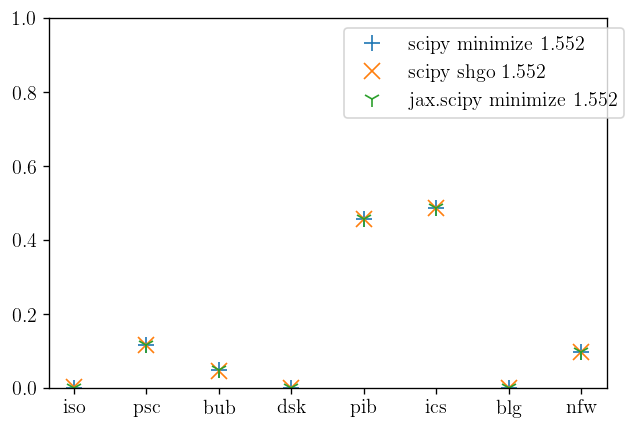

In [ ]:
m_s = ['+', 'x', '1']

fig, ax = plt.subplots()
for method, result, m in zip(methods, results, m_s):
    ax.plot(np.exp(result.x), marker=m, ls='None', ms=10, label=method+f' {result.fun:.3f}')

ax.set(ylim=(0,1))
ax.set_xticks(list(range(8)))
ax.set_xticklabels(['iso', 'psc', 'bub', 'dsk', 'pib', 'ics', 'blg', 'nfw'])
ax.legend(bbox_to_anchor=(1.05, 1.0));